In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

In [2]:
raw_dat = pd.read_excel("../data/raw_data.xlsx")
raw_dat['Normalized'] = (raw_dat['mkt_r'] - raw_dat['dep_f_r'])/(raw_dat['len_f_r'] - raw_dat['dep_f_r'])
dat = raw_dat.drop(columns=['mkt_r', 'dep_f_r', 'len_f_r'])
dat.to_csv("../data/reserve_demand_cruve_data.csv", index=False)

# Non-Parametric Modeling

In [3]:
import reserves_demand.curve_nparam_fit as npcf

In [4]:
obj = npcf.CurveNonParamFit(
    data = dat, 
    dep_var = 'Normalized',
    main_indep_var= 'excess_reserve',
    dep_var_name= 'Normalized Overnight Rate',                 
    main_indep_var_name= 'Excess Reserve',
    nFolds=5,
)

Running cross-validation for GAM Splines model
Best parameters for GAM Splines: {'lam': 0.001, 'model_type': 'linear', 'n_splines': 10}
Training Metrics:
RMSE         0.062440
MAE          0.041348
MAPE        25.826822
R2           0.906857
MSLE         0.002505
MedianAE     0.022303
dtype: float64

Validation Metrics:
RMSE         0.069023
MAE          0.046757
MAPE        31.508207
R2           0.887747
MSLE         0.003142
MedianAE     0.026340
dtype: float64


Running cross-validation for Random Forest model
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training Metrics:
RMSE        0.017607
MAE         0.011441
MAPE        6.455826
R2          0.992594
MSLE        0.000190
MedianAE    0.006411
dtype: float64

Validation Metrics:
RMSE         0.048457
MAE          0.031612
MAPE        20.930702
R2           0.944674
MSLE         0.001547
MedianAE     0.013021
dtype: float64


Best model based on Validation

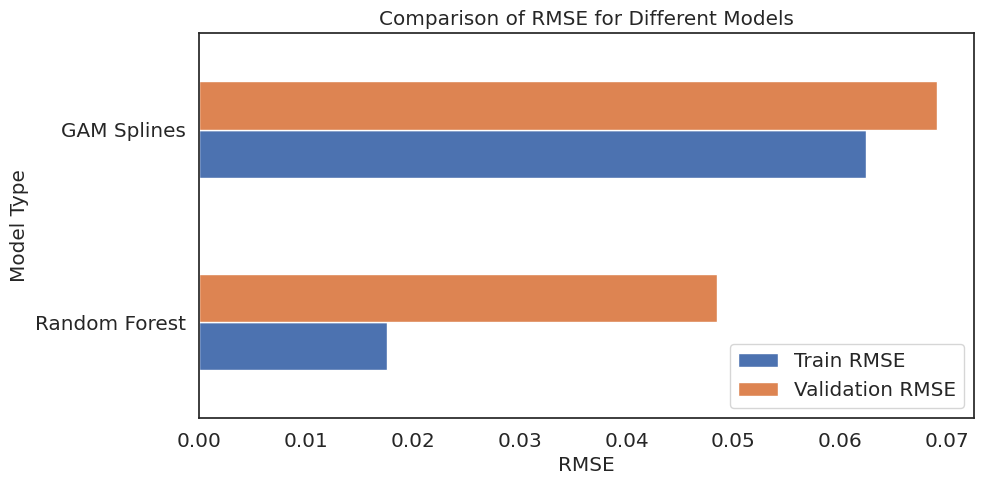

Model Type,GAM Splines,Random Forest
Train RMSE,0.062440,0.017607
Train MAE,0.041348,0.011441
Train MAPE,25.826822,6.455826
Train R2,0.906857,0.992594
Train MSLE,0.002505,0.000190
Train MedianAE,0.022303,0.006411
Validation RMSE,0.069023,0.048457
Validation MAE,0.046757,0.031612
Validation MAPE,31.508207,20.930702
Validation R2,0.887747,0.944674


In [5]:
best_model_type, comparison_result  = obj.compare_models(verbose = True, plot=True)
comparison_result.set_index('Model Type').T

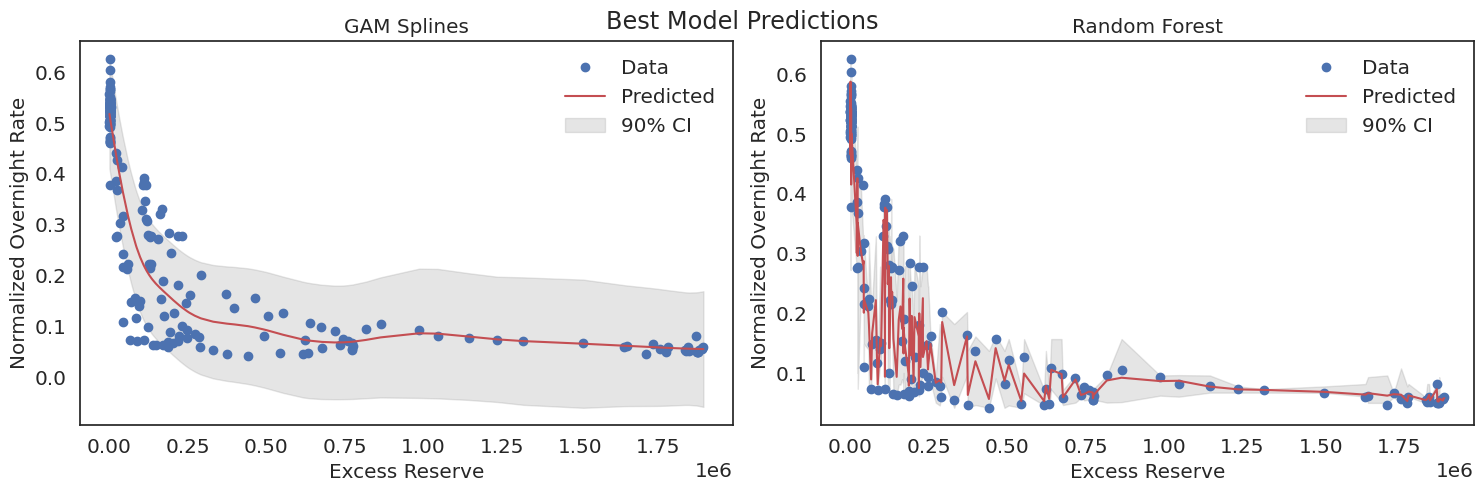

In [6]:
obj.plot_best()

In [7]:
forecast_input = dat.tail(2).drop(columns=['Normalized'])
forecast_output = obj.predict_best('Best Model', X=forecast_input)
forecast_output

,excess_reserve,ovn_vol,vix,acnusd,hicp,ypred,ypred_upper,ypred_lower
228,0.927237,0.031745,0.468667,1.504435,3.387595,0.064152,0.050406,0.108131
229,0.903961,0.042783,0.414104,1.495997,3.391160,0.062520,0.050373,0.096312


# Parametric Modeling

In [ ]:
import pandas as pd
import numpy as np
from reserves_demand.curve_fit import CurveParamFit

# Load the dataset
data = pd.read_csv('data.csv')

# Initialize the CurveParamFit object
curve_fit = CurveParamFit(
            data = dat, 
            dep_var = 'Normalized',
            main_indep_var= 'excess_reserve',
            dep_var_name= 'Normalized Overnight Rate',                 
            main_indep_var_name= 'Excess Reserve',
        )

# Perform variable selection for each curve
best_curve, varselect_result = curve_fit.variable_select(on='RMSE', verbose=True, plot=True)

# Fit the best curves
best_curves_params = curve_fit.fit_best_curves()

# Compare the best curves
perf_metrics_df, predictions_df, param_df = curve_fit.compare_best_curves()

# Predict the dependent variable using the best curve
predictions = curve_fit.predict_best_curve(best_curve)

# Estimate the most probable value of a variable
known_value = ('Normalized', 100)
most_probable_value = curve_fit.most_probable_value(best_curve, known_value)

In [8]:
import reserves_demand.curve_param_fit as pcf
obj = pcf.CurveParamFit(
    data = dat, 
    dep_var = 'Normalized',
    main_indep_var= 'excess_reserve',
    dep_var_name= 'Normalized Overnight Rate',                 
    main_indep_var_name= 'Excess Reserve',
    constant = True,
    Q = 0.9,
    nFolds=5,
    parallel=True,
    search_method = 'all_combinations'
)

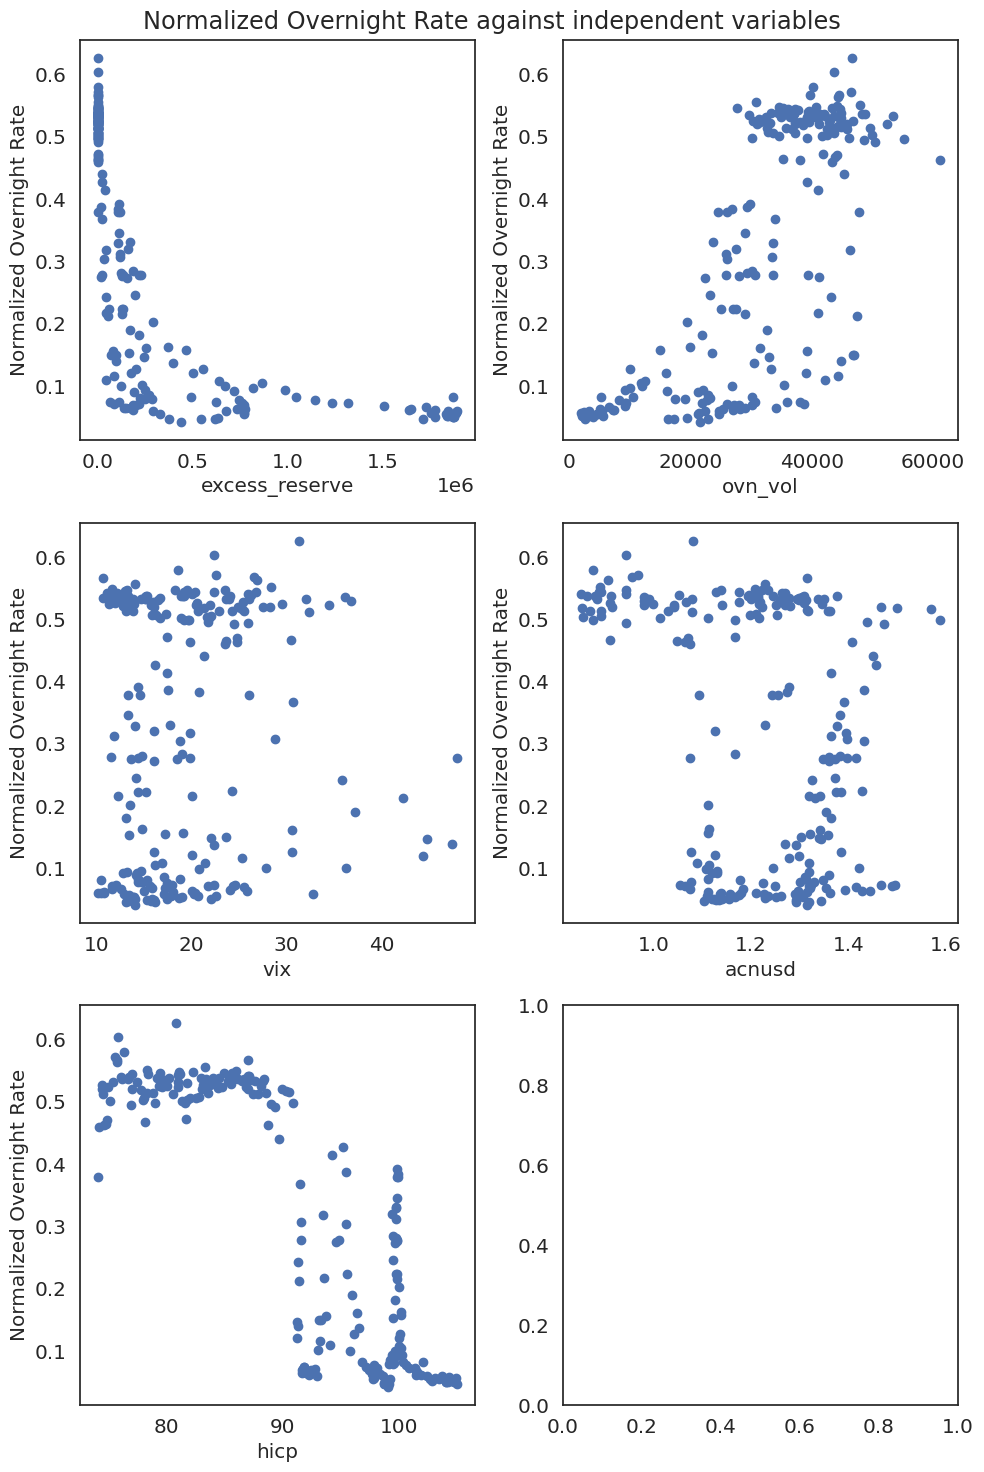

In [9]:
_ = obj.plot_x_y()

Running cross-validation for logistic curve


100%|██████████| 63/63 [00:03<00:00, 16.83 it/s]

Best combination for logistic: ['excess_reserve', 'ovn_vol', 'vix', 'acnusd', 'hicp']
Training Metrics:
RMSE         0.059261
MAE          0.040002
MAPE        26.204629
R2           0.916200
MSLE         0.002300
MedianAE     0.022643
dtype: float64

Validation Metrics:
RMSE         0.058856
MAE          0.040513
MAPE        26.673115
R2           0.915567
MSLE         0.002301
MedianAE     0.023291
dtype: float64


Running cross-validation for redLogistic curve



100%|██████████| 63/63 [00:02<00:00, 21.83 it/s]

Best combination for redLogistic: ['excess_reserve', 'vix', 'acnusd']
Training Metrics:
RMSE         0.060841
MAE          0.041941
MAPE        27.096053
R2           0.911773
MSLE         0.002404
MedianAE     0.024511
dtype: float64

Validation Metrics:
RMSE         0.061318
MAE          0.042960
MAPE        27.542161
R2           0.908273
MSLE         0.002474
MedianAE     0.025147
dtype: float64


Running cross-validation for fixLogistic curve



100%|██████████| 63/63 [00:01<00:00, 31.94 it/s] 

Best combination for fixLogistic: ['constant', 'excess_reserve', 'vix', 'acnusd']
Training Metrics:
RMSE         0.060841
MAE          0.041941
MAPE        27.096774
R2           0.911773
MSLE         0.002404
MedianAE     0.024515
dtype: float64

Validation Metrics:
RMSE         0.061319
MAE          0.042961
MAPE        27.543350
R2           0.908269
MSLE         0.002474
MedianAE     0.025144
dtype: float64


Running cross-validation for doubleExp curve



100%|██████████| 63/63 [00:03<00:00, 16.56 it/s]

Best combination for doubleExp: ['excess_reserve', 'vix', 'acnusd']
Training Metrics:
RMSE         0.060413
MAE          0.041499
MAPE        27.031617
R2           0.913014
MSLE         0.002376
MedianAE     0.024025
dtype: float64

Validation Metrics:
RMSE         0.060971
MAE          0.042510
MAPE        27.466822
R2           0.909366
MSLE         0.002451
MedianAE     0.026418
dtype: float64


Running cross-validation for exponential curve



100%|██████████| 63/63 [00:03<00:00, 19.54 it/s]

Best combination for exponential: ['constant', 'excess_reserve', 'vix', 'acnusd']
Training Metrics:
RMSE         0.061378
MAE          0.042556
MAPE        27.208474
R2           0.910206
MSLE         0.002432
MedianAE     0.025520
dtype: float64

Validation Metrics:
RMSE         0.061893
MAE          0.043580
MAPE        27.656473
R2           0.906502
MSLE         0.002505
MedianAE     0.025704
dtype: float64


Running cross-validation for fixExponential curve



100%|██████████| 63/63 [00:00<00:00, 130.10 it/s]

Best combination for fixExponential: ['excess_reserve', 'vix', 'acnusd']
Training Metrics:
RMSE         0.069475
MAE          0.053688
MAPE        41.305933
R2           0.884991
MSLE         0.003331
MedianAE     0.047538
dtype: float64

Validation Metrics:
RMSE         0.069997
MAE          0.054602
MAPE        41.492268
R2           0.881079
MSLE         0.003405
MedianAE     0.047447
dtype: float64


Running cross-validation for arctan curve



100%|██████████| 63/63 [00:02<00:00, 23.60 it/s]

Best combination for arctan: ['constant', 'excess_reserve', 'vix']
Training Metrics:
RMSE         0.059295
MAE          0.039544
MAPE        26.468534
R2           0.916209
MSLE         0.002308
MedianAE     0.020991
dtype: float64

Validation Metrics:
RMSE         0.059465
MAE          0.040059
MAPE        26.823928
R2           0.913893
MSLE         0.002356
MedianAE     0.021366
dtype: float64


Running cross-validation for linear curve



100%|██████████| 63/63 [00:00<00:00, 240.00 it/s]


Best combination for linear: ['constant', 'excess_reserve', 'ovn_vol', 'vix', 'hicp']
Training Metrics:
RMSE         0.094525
MAE          0.073818
MAPE        58.335022
R2           0.787055
MSLE              NaN
MedianAE     0.060117
dtype: float64

Validation Metrics:
RMSE         0.095018
MAE          0.074744
MAPE        59.038136
R2           0.780222
MSLE         0.003706
MedianAE     0.063482
dtype: float64


Best curve based on Validation RMSE: logistic curve


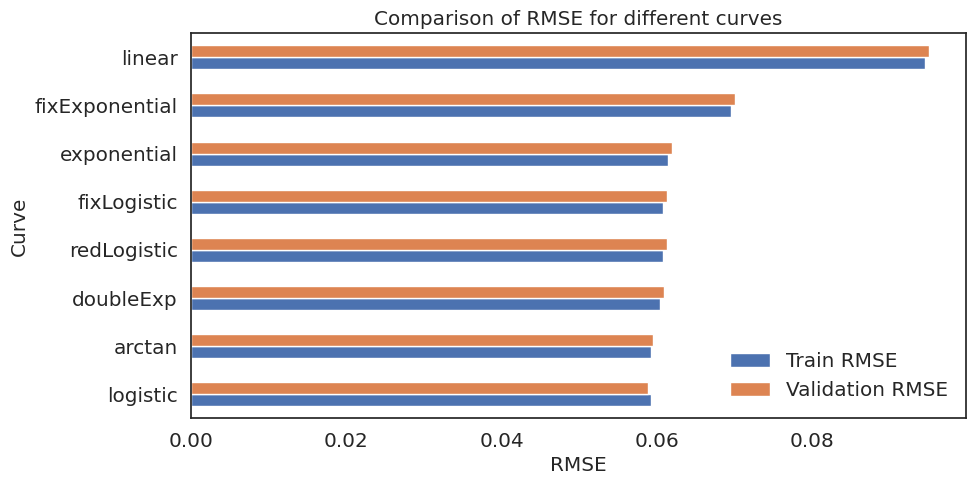

Curve,logistic,redLogistic,fixLogistic,doubleExp,exponential,fixExponential,arctan,linear
Best Combination,"[excess_reserve, ovn_vol, vix, acnusd, hicp]","[excess_reserve, vix, acnusd]","[constant, excess_reserve, vix, acnusd]","[excess_reserve, vix, acnusd]","[constant, excess_reserve, vix, acnusd]","[excess_reserve, vix, acnusd]","[constant, excess_reserve, vix]","[constant, excess_reserve, ovn_vol, vix, hicp]"
Train RMSE,0.059261,0.060841,0.060841,0.060413,0.061378,0.069475,0.059295,0.094525
Train MAE,0.040002,0.041941,0.041941,0.041499,0.042556,0.053688,0.039544,0.073818
Train MAPE,26.204629,27.096053,27.096774,27.031617,27.208474,41.305933,26.468534,58.335022
Train R2,0.9162,0.911773,0.911773,0.913014,0.910206,0.884991,0.916209,0.787055
Train MSLE,0.0023,0.002404,0.002404,0.002376,0.002432,0.003331,0.002308,NaN
Train MedianAE,0.022643,0.024511,0.024515,0.024025,0.02552,0.047538,0.020991,0.060117
Validation RMSE,0.058856,0.061318,0.061319,0.060971,0.061893,0.069997,0.059465,0.095018
Validation MAE,0.040513,0.04296,0.042961,0.04251,0.04358,0.054602,0.040059,0.074744
Validation MAPE,26.673115,27.542161,27.54335,27.466822,27.656473,41.492268,26.823928,59.038136


In [10]:
best_curve, cv_result = obj.variable_select(on='RMSE', verbose=True, plot=True)
cv_result.set_index('Curve').T

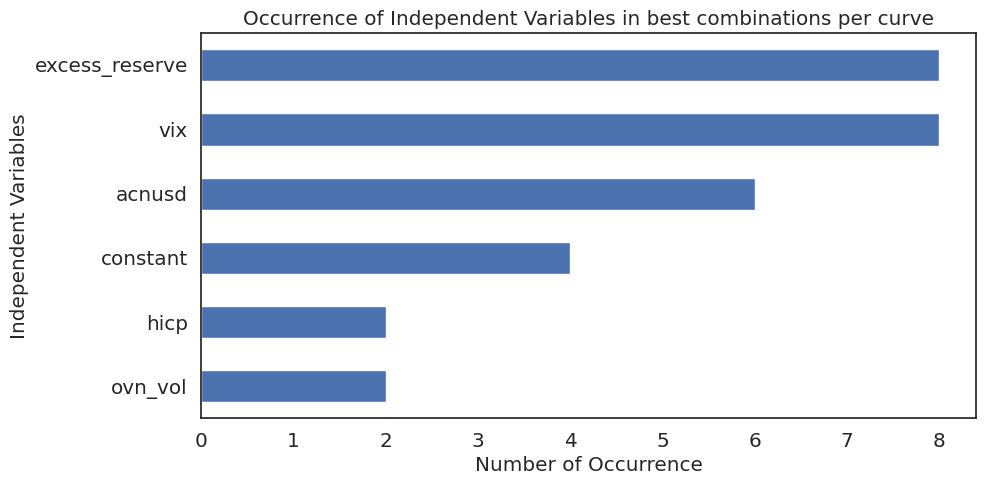

ovn_vol           2
hicp              2
constant          4
acnusd            6
vix               8
excess_reserve    8
dtype: int64

In [11]:
obj.indep_vars_occurence(normalize=False)

In [12]:
best_params = obj.fit_best_curves()

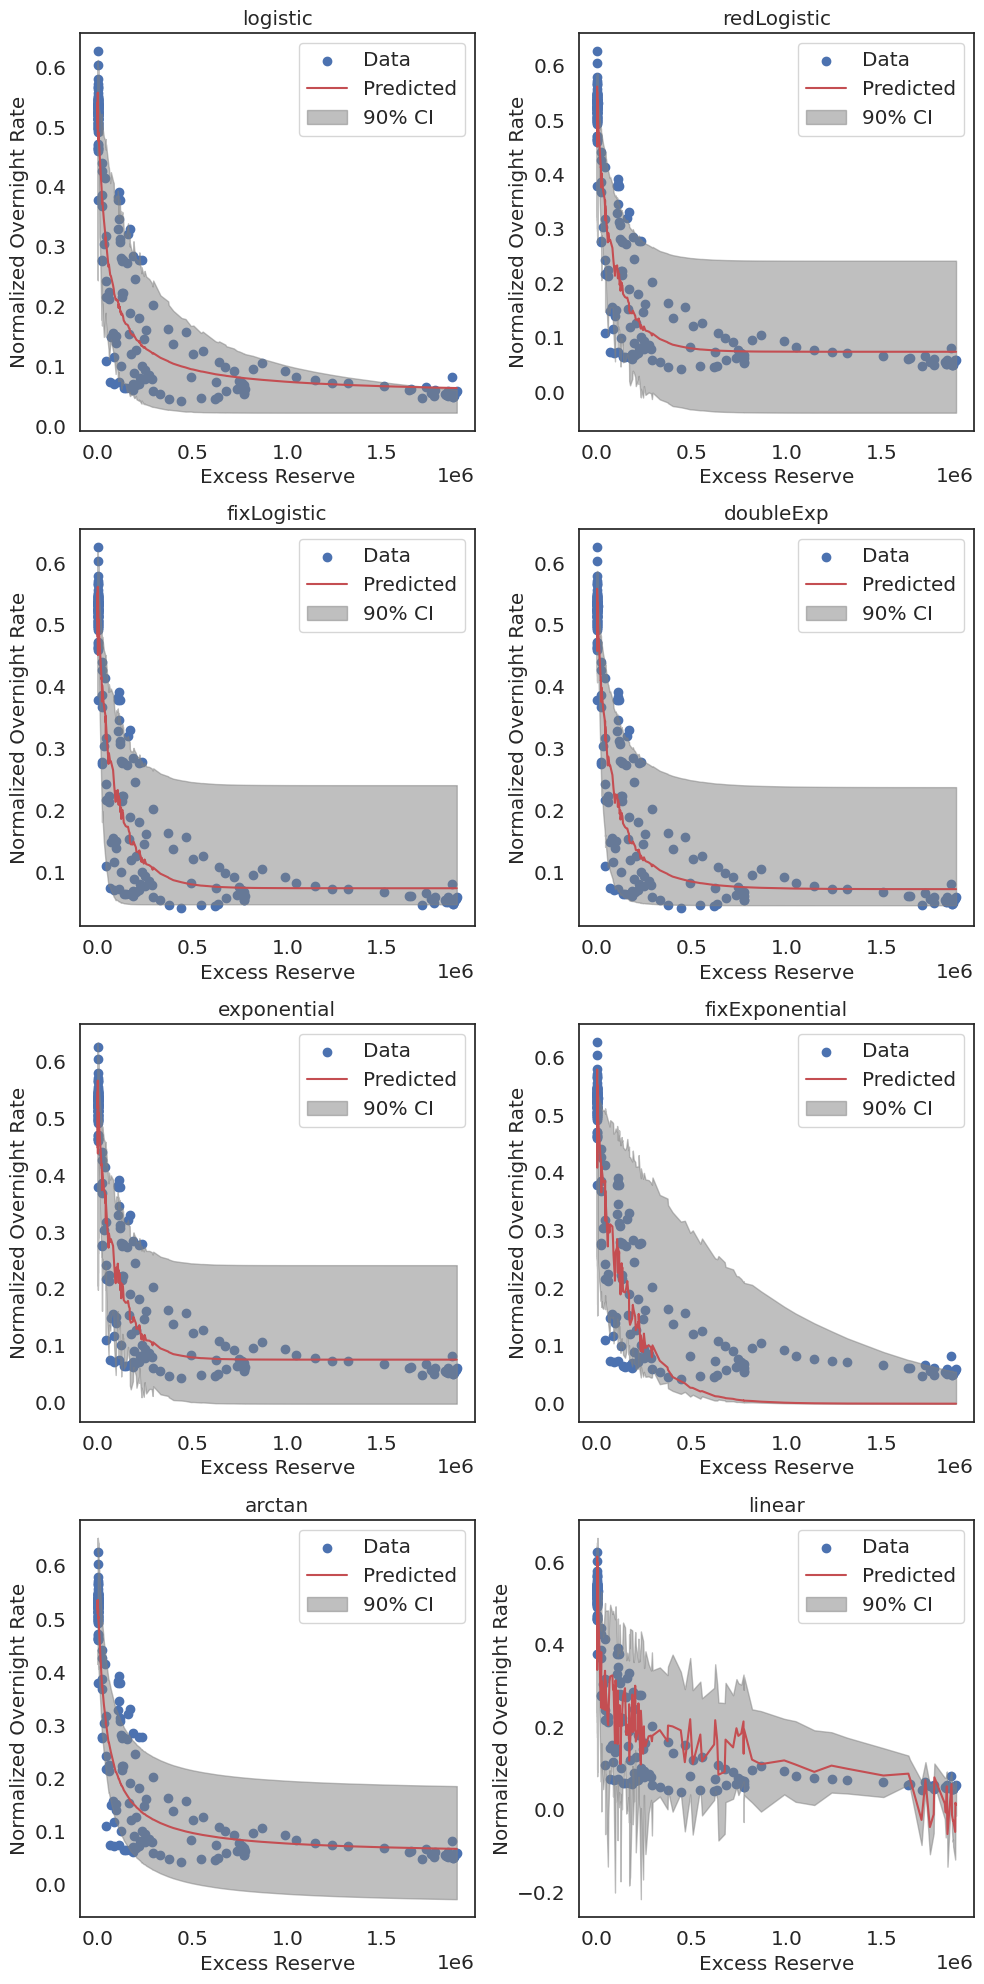

In [13]:
perf_metrics_df, predictions_df, param_df = obj.compare_best_curves(CI = True)

In [14]:
perf_metrics_df

,logistic,redLogistic,fixLogistic,doubleExp,exponential,fixExponential,arctan,linear
RMSE,0.058741,0.060991,0.060991,0.060568,0.061533,0.069614,0.059404,0.094708
MAE,0.039329,0.042117,0.042118,0.041668,0.042692,0.053778,0.039558,0.073883
MAPE,26.075165,27.170532,27.171088,27.082910,27.272428,41.329487,26.480056,58.421958
R2,0.917890,0.911479,0.911479,0.912703,0.909899,0.884681,0.916028,0.786559
MSLE,0.002263,0.002412,0.002412,0.002384,0.002440,0.003341,0.002314,NaN
MedianAE,0.021109,0.024902,0.024906,0.023978,0.025350,0.048221,0.020372,0.059377
MIS,0.234032,0.249851,0.219250,0.199408,0.265215,0.303824,0.267551,0.342868


In [15]:
predictions_df.head()

logistic                                                          \
  excess_reserve       ovn_vol        vix    acnusd       hicp     ypred   
0     141.434783  48635.812500  25.923333  0.943000  76.930000  0.526017   
1     288.800000  42447.772727  16.651905  1.216732  81.759000  0.521982   
2     302.382353  30843.666667  14.007500  1.228317  83.332941  0.534037   
3     384.266667  38065.952381  20.411364  1.140655  81.021000  0.524015   
4     449.838710  33244.000000  19.033333  0.880886  79.143548  0.557379   

                             redLogistic             ...      arctan  \
  ypred_upper ypred_lower excess_reserve        vix  ... ypred_upper   
0    0.465264    0.584586     141.434783  25.923333  ...    0.430448   
1    0.416354    0.551426     288.800000  16.651905  ...    0.438903   
2    0.332491    0.553056     302.382353  14.007500  ...    0.441659   
3    0.362990    0.559558     384.266667  20.411364  ...    0.433909   
4    0.364009    0.607284     449.838710  19.033333  ...    0.434734   

                linear                                                     \
  ypred_lower constant excess_reserve       ovn_vol        vix       hicp   
0    0.641748        1     141.434783  48635.812500  25.923333  76.930000   
1    0.650169        1     288.800000  42447.772727  16.651905  81.759000   
2    0.652914        1     302.382353  30843.666667  14.007500  83.332941   
3    0.645196        1     384.266667  38065.952381  20.411364  81.021000   
4    0.646018        1     449.838710  33244.000000  19.033333  79.143548   

                                     
      ypred ypred_upper ypred_lower  
0  0.558837    0.392317    0.639636  
1  0.530356    0.395607    0.594551  
2  0.485406    0.385055    0.546743  
3  0.499283    0.361872    0.579485  
4  0.521989    0.417966    0.580771  

[5 rows x 54 columns]

In [16]:
param_df.loc['logistic']

,avg,upper bound,lower bound
alpha,0.051115,0.007885,-0.716429
beta,0.994662,0.988682,1.608731
kappa,0.002133,0.004956,0.739686
excess_reserve,-0.172055,-0.088773,-16.759425
ovn_vol,-0.000182,0.000393,0.841431
vix,-0.000580,-0.000346,-0.543410
acnusd,-0.000943,-0.002520,-0.024853
hicp,0.001054,0.002373,-0.702453


In [17]:
forecast_input = dat.tail(2).drop(columns=['Normalized'])
forecast_output = obj.predict_best_curve('logistic', X=forecast_input)
forecast_output

,excess_reserve,ovn_vol,vix,acnusd,hicp,ypred,ypred_upper,ypred_lower
228,1.755207e+06,1881.485714,17.766765,1.108923,104.928571,0.065295,0.023257,0.065719
229,1.711147e+06,2535.666667,15.698333,1.102703,105.039000,0.065627,0.023257,0.067059


In [18]:
obj.most_probable_value(curvename='logistic', known_value=('excess_reserve', 1755207), verbose=True)

Estimated value of Excess Reserve at 1755207: 0.06529519200285594


0.06529519200285594

In [19]:
obj.most_probable_value(curvename='logistic', known_value=('Normalized', 0.38), verbose=True)

Estimated value of Normalized Overnight Rate at 0.38: 23484.25664268179


23484.25664268179

# Parametric Additive Model

In [20]:
import reserves_demand.curve_paramadd_fit as pcf
obj = pcf.CurveParamAdditiveFit(
    data = dat, 
    dep_var = 'Normalized',
    main_indep_var= 'excess_reserve',
    dep_var_name= 'Normalized Overnight Rate',                 
    main_indep_var_name= 'Excess Reserve',
    Q = 0.9,
    nFolds=5,
    parallel=True,
    search_method = 'all_combinations'
)

Running cross-validation for logistic curve


100%|██████████| 16/16 [00:04<00:00,  3.83 it/s]

Best combination for logistic: ['excess_reserve', 'acnusd', 'hicp']
Training Metrics:
RMSE         0.053576
MAE          0.036998
MAPE        23.808108
R2           0.931630
MSLE         0.001849
MedianAE     0.024010
dtype: float64

Validation Metrics:
RMSE         0.054991
MAE          0.037931
MAPE        24.277969
R2           0.926930
MSLE         0.001955
MedianAE     0.025339
dtype: float64


Running cross-validation for redLogistic curve



100%|██████████| 16/16 [00:00<00:00, 19.25 it/s]

Best combination for redLogistic: ['excess_reserve', 'acnusd', 'hicp', 'vix']
Training Metrics:
RMSE         0.058171
MAE          0.040872
MAPE        27.184220
R2           0.919379
MSLE         0.002213
MedianAE     0.029174
dtype: float64

Validation Metrics:
RMSE         0.060155
MAE          0.042049
MAPE        27.620675
R2           0.912295
MSLE         0.002390
MedianAE     0.028603
dtype: float64


Running cross-validation for fixLogistic curve



100%|██████████| 16/16 [00:00<00:00, 17.00 it/s]

Best combination for fixLogistic: ['excess_reserve', 'acnusd', 'hicp', 'vix']
Training Metrics:
RMSE         0.100821
MAE          0.078025
MAPE        57.545180
R2           0.757739
MSLE         0.006779
MedianAE     0.063231
dtype: float64

Validation Metrics:
RMSE         0.101470
MAE          0.079543
MAPE        58.772897
R2           0.749419
MSLE         0.005945
MedianAE     0.066139
dtype: float64


Running cross-validation for doubleExp curve



100%|██████████| 16/16 [00:04<00:00,  3.41 it/s]

Best combination for doubleExp: ['excess_reserve', 'acnusd', 'hicp', 'vix']
Training Metrics:
RMSE         0.057431
MAE          0.040086
MAPE        26.476879
R2           0.921418
MSLE         0.002150
MedianAE     0.028008
dtype: float64

Validation Metrics:
RMSE         0.059442
MAE          0.041289
MAPE        26.993428
R2           0.914380
MSLE         0.002325
MedianAE     0.028486
dtype: float64


Running cross-validation for exponential curve



100%|██████████| 16/16 [00:00<00:00, 23.66 it/s]

Best combination for exponential: ['excess_reserve', 'acnusd', 'vix']
Training Metrics:
RMSE         0.060611
MAE          0.042555
MAPE        27.223528
R2           0.912448
MSLE         0.002391
MedianAE     0.027535
dtype: float64

Validation Metrics:
RMSE         0.061744
MAE          0.043424
MAPE        27.542708
R2           0.907211
MSLE         0.002521
MedianAE     0.027809
dtype: float64


Running cross-validation for fixExponential curve



100%|██████████| 16/16 [00:00<00:00, 30.80 it/s]

Best combination for fixExponential: ['excess_reserve', 'acnusd', 'hicp', 'vix']
Training Metrics:
RMSE         0.060013
MAE          0.042145
MAPE        27.684423
R2           0.914189
MSLE         0.002352
MedianAE     0.029729
dtype: float64

Validation Metrics:
RMSE         0.061445
MAE          0.043128
MAPE        28.065689
R2           0.908440
MSLE         0.002495
MedianAE     0.029600
dtype: float64


Running cross-validation for arctan curve



100%|██████████| 16/16 [00:00<00:00, 23.74 it/s]

Best combination for arctan: ['excess_reserve', 'acnusd', 'hicp']
Training Metrics:
RMSE         0.057342
MAE          0.039284
MAPE        25.497330
R2           0.921677
MSLE         0.002121
MedianAE     0.025717
dtype: float64

Validation Metrics:
RMSE         0.059377
MAE          0.040554
MAPE        26.044248
R2           0.914762
MSLE         0.002279
MedianAE     0.026912
dtype: float64


Running cross-validation for linear curve



100%|██████████| 16/16 [00:00<00:00, 51.78 it/s]


Best combination for linear: ['excess_reserve', 'hicp', 'ovn_vol', 'vix']
Training Metrics:
RMSE         0.094525
MAE          0.073816
MAPE        58.333299
R2           0.787055
MSLE              NaN
MedianAE     0.060123
dtype: float64

Validation Metrics:
RMSE         0.095018
MAE          0.074743
MAPE        59.038661
R2           0.780224
MSLE         0.003707
MedianAE     0.063478
dtype: float64


Best curve based on Validation RMSE: logistic curve


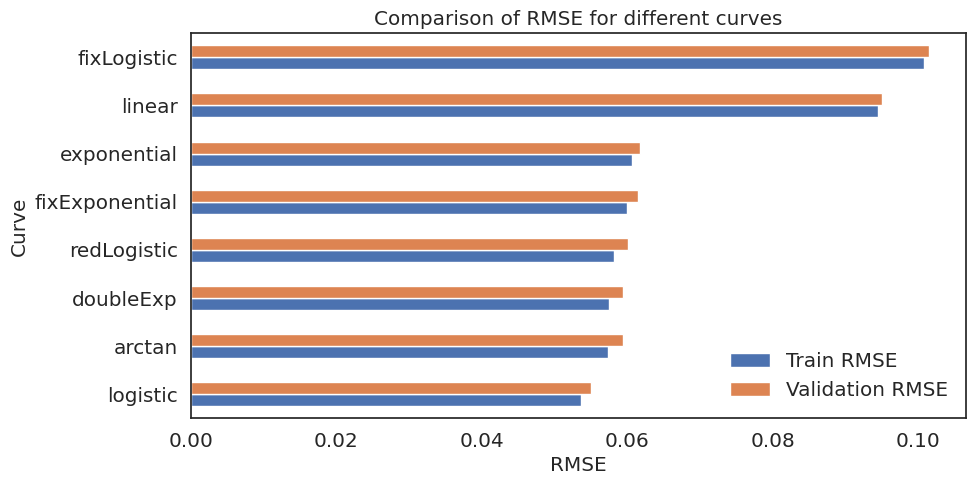

Curve,logistic,redLogistic,fixLogistic,doubleExp,exponential,fixExponential,arctan,linear
Best Combination,"[excess_reserve, acnusd, hicp]","[excess_reserve, acnusd, hicp, vix]","[excess_reserve, acnusd, hicp, vix]","[excess_reserve, acnusd, hicp, vix]","[excess_reserve, acnusd, vix]","[excess_reserve, acnusd, hicp, vix]","[excess_reserve, acnusd, hicp]","[excess_reserve, hicp, ovn_vol, vix]"
Train RMSE,0.053576,0.058171,0.100821,0.057431,0.060611,0.060013,0.057342,0.094525
Train MAE,0.036998,0.040872,0.078025,0.040086,0.042555,0.042145,0.039284,0.073816
Train MAPE,23.808108,27.18422,57.54518,26.476879,27.223528,27.684423,25.49733,58.333299
Train R2,0.93163,0.919379,0.757739,0.921418,0.912448,0.914189,0.921677,0.787055
Train MSLE,0.001849,0.002213,0.006779,0.00215,0.002391,0.002352,0.002121,NaN
Train MedianAE,0.02401,0.029174,0.063231,0.028008,0.027535,0.029729,0.025717,0.060123
Validation RMSE,0.054991,0.060155,0.10147,0.059442,0.061744,0.061445,0.059377,0.095018
Validation MAE,0.037931,0.042049,0.079543,0.041289,0.043424,0.043128,0.040554,0.074743
Validation MAPE,24.277969,27.620675,58.772897,26.993428,27.542708,28.065689,26.044248,59.038661


In [21]:
best_curve, cv_result = obj.variable_select(on='RMSE', verbose=True, plot=True)
cv_result.set_index('Curve').T

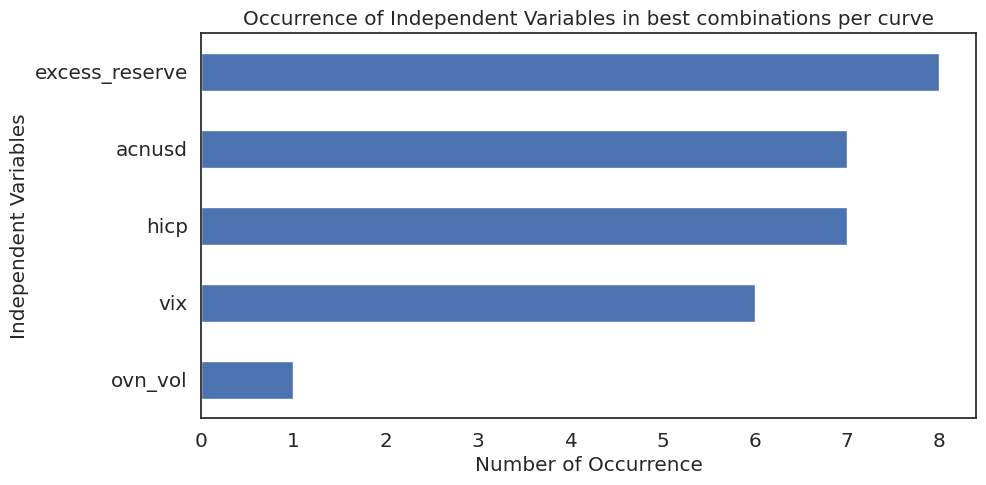

ovn_vol           1
vix               6
hicp              7
acnusd            7
excess_reserve    8
dtype: int64

In [22]:
obj.indep_vars_occurence(normalize=False)

In [23]:
best_params = obj.fit_best_curves()

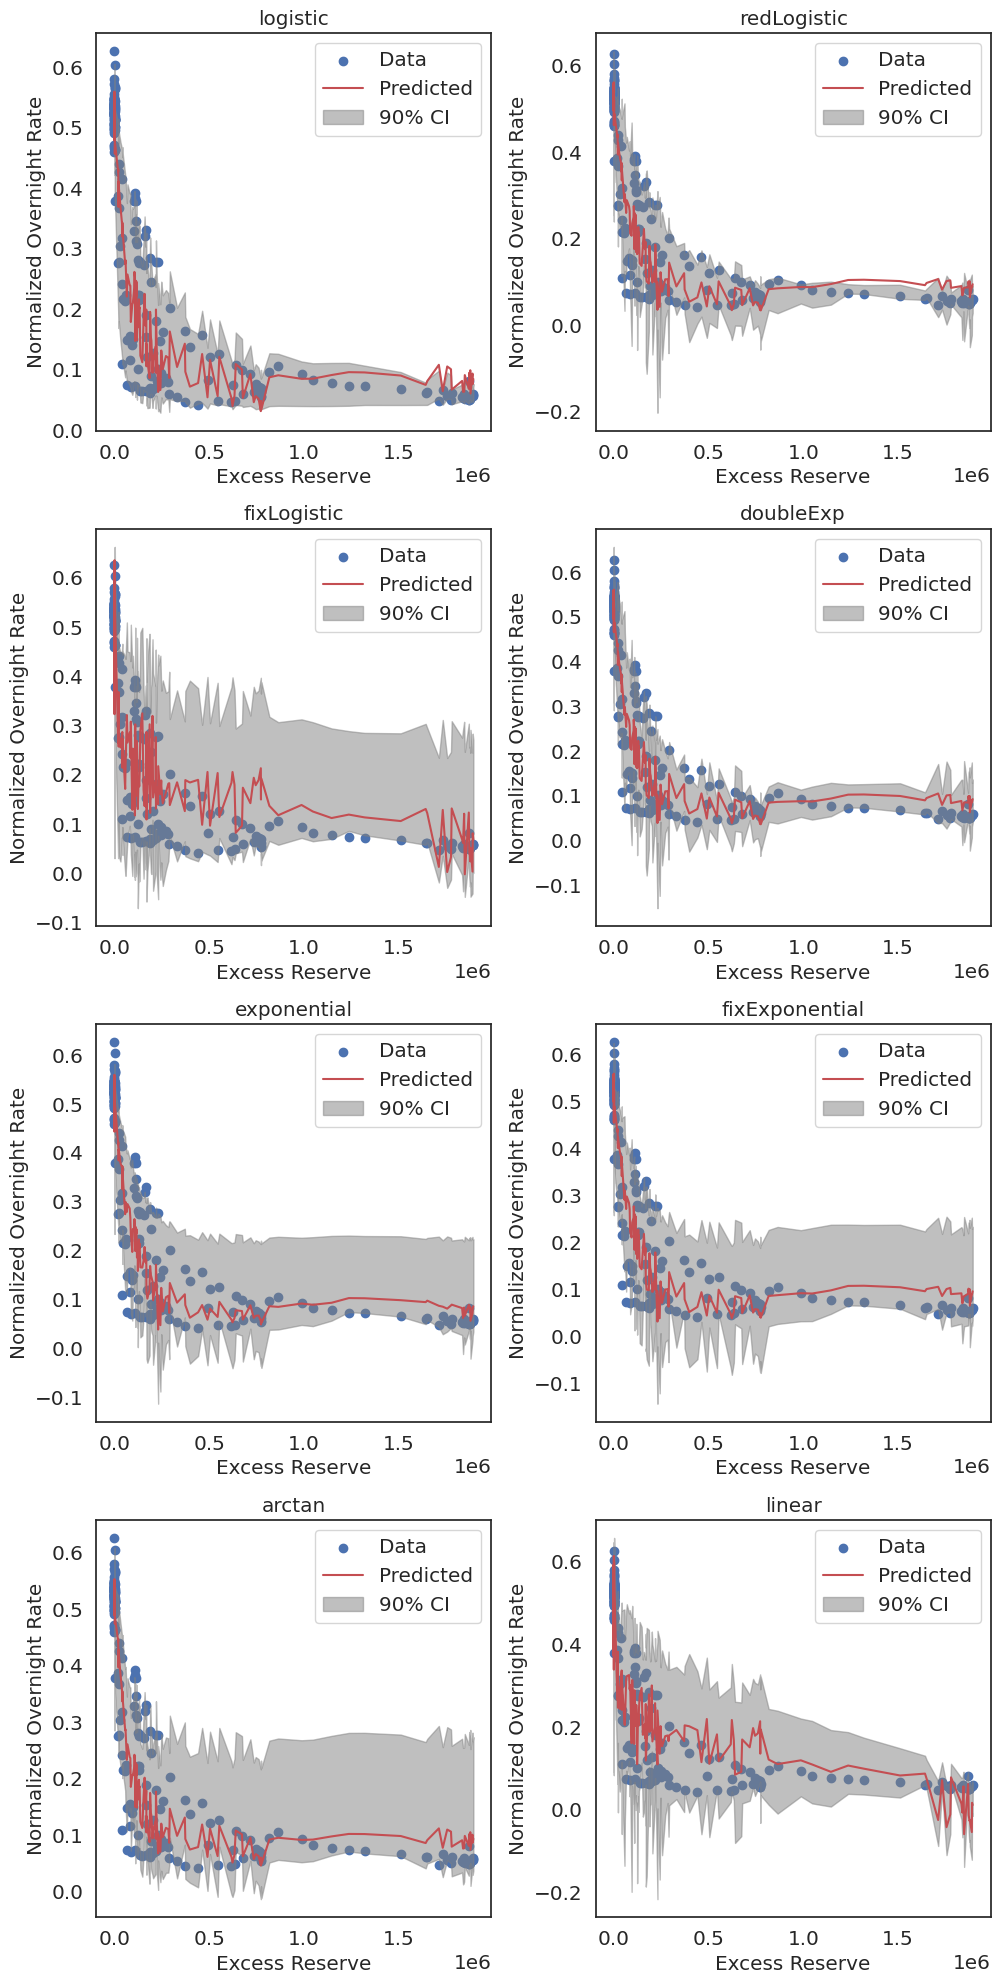

In [24]:
perf_metrics_df, predictions_df, param_df = obj.compare_best_curves(CI = True)

In [25]:
perf_metrics_df

,logistic,redLogistic,fixLogistic,doubleExp,exponential,fixExponential,arctan,linear
RMSE,0.053759,0.058433,0.101014,0.057693,0.060813,0.060221,0.057590,0.094708
MAE,0.037128,0.040986,0.078183,0.040216,0.042699,0.042250,0.039459,0.073883
MAPE,23.846757,27.170126,57.679505,26.521276,27.280080,27.696798,25.551036,58.421915
R2,0.931228,0.918751,0.757189,0.920795,0.911996,0.913701,0.921077,0.786559
MSLE,0.001859,0.002230,NaN,0.002167,0.002405,0.002366,0.002136,NaN
MedianAE,0.023876,0.029628,0.062012,0.029203,0.027521,0.028864,0.025810,0.059377
MIS,0.170087,0.212973,0.359839,0.208133,0.243121,0.257301,0.244261,0.343903


In [26]:
forecast_input = dat.tail(2).drop(columns=['Normalized'])
forecast_output = obj.predict_best_curve('logistic', X=forecast_input)
forecast_output

,excess_reserve,acnusd,hicp,ypred,ypred_upper,ypred_lower
228,1.755207e+06,1.108923,104.928571,0.105338,0.051888,0.095213
229,1.711147e+06,1.102703,105.039000,0.108074,0.052265,0.098349


In [27]:
obj.most_probable_value(curvename='logistic', known_value=('excess_reserve', 1755207), verbose=True)

Estimated value of Excess Reserve at 1755207: 0.10533735935638935


0.10533735935638935

In [28]:
obj.most_probable_value(curvename='logistic', known_value=('Normalized', 0.38), verbose=True)

Estimated value of Normalized Overnight Rate at 0.38: 28051.0306854215


28051.0306854215